# Library Imports #

In [ ]:
from math import sqrt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sborn
import warnings
from datetime import datetime
%matplotlib inline
import scipy.stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Read Data from CSVs #

In [ ]:
state_data_list = ["Andhra Pradesh","MP","Rajasthan1","Tamil Nadu"]
data = {}
for state in state_data_list:
    data[state] = []
 
for state in state_data_list:
    statedir="./Renewable Energy Data"+'/'+state;
    for file in sorted(os.listdir(statedir), key=lambda file_name: file_name[-8:]): #Read from *2000.csv to *2014.csv in order
        data_tmp = pd.read_csv(statedir+'/'+file, skiprows=2, parse_dates={'Date_Time': ['Year','Month','Day','Hour']}, date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))
        data[state].extend(data_tmp.values) 

In [ ]:
column_names = ['Date_Time','Minute','DHI','DNI','GHI','Clearsky DHI','Clearsky DNI','Clearsky GHI','Dew Point','Temperature','Pressure','Relative Humidity','Solar Zenith Angle','Snow depth','Wind Speed','NAN']
MP_data = pd.DataFrame(data['MP'],columns=column_names)[pd.DataFrame(data['MP'],columns=column_names)['Wind Speed'].notna()]
MP_data.name = 'Madhya Pradesh'
MP_data.head()

,Date_Time,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Snow depth,Wind Speed,NAN
0,2000-01-01 00:00:00,0,0,0,0,0,0,0,3,13.986429,964.509827,48.661484,175.597127,0,2.733917,NaN
1,2000-01-01 01:00:00,0,0,0,0,0,0,0,3,13.684157,964.110107,50.296294,162.005468,0,2.660168,NaN
2,2000-01-01 02:00:00,0,0,0,0,0,0,0,3,13.329301,963.844177,51.627187,148.352035,0,2.655523,NaN
3,2000-01-01 03:00:00,0,0,0,0,0,0,0,3,13.000682,963.355286,52.655196,134.784919,0,2.693983,NaN
4,2000-01-01 04:00:00,0,0,0,0,0,0,0,3,12.782371,963.358093,54.141549,121.369895,0,2.719821,NaN


In [ ]:
MP_data.shape

(131400, 16)

In [ ]:
RJ_data = pd.DataFrame(data['Rajasthan1'],columns=column_names)[pd.DataFrame(data['Rajasthan1'],columns=column_names)['Wind Speed'].notna()]
RJ_data.name = 'Rajasthan'
RJ_data.head()

,Date_Time,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Snow depth,Wind Speed,NAN
0,2000-01-01 00:00:00,0,0,0,0,0,0,0,-4,13.811437,982.749817,27.447862,174.755997,0,3.976945,NaN
1,2000-01-01 01:00:00,0,0,0,0,0,0,0,-4,13.117300,982.670105,29.048857,169.544205,0,4.017371,NaN
2,2000-01-01 02:00:00,0,0,0,0,0,0,0,-4,12.433960,982.404175,31.216659,156.340938,0,3.992325,NaN
3,2000-01-01 03:00:00,0,0,0,0,0,0,0,-3,11.797632,982.555298,34.956075,142.945864,0,3.981812,NaN
4,2000-01-01 04:00:00,0,0,0,0,0,0,0,-1,11.195487,982.558105,41.177540,129.625767,0,3.985008,NaN


In [ ]:
RJ_data.shape

(131400, 16)

In [ ]:
TN_data = pd.DataFrame(data['Tamil Nadu'],columns=column_names)[pd.DataFrame(data['Tamil Nadu'],columns=column_names)['Wind Speed'].notna()]
TN_data.name = 'Tamil Nadu'
TN_data.head()

,Date_Time,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Snow depth,Wind Speed,NAN
0,2000-01-01 00:00:00,0,0,0,0,0,0,0,21,22.361598,951.069824,94.747772,166.221817,0,0.443917,NaN
1,2000-01-01 01:00:00,0,0,0,0,0,0,0,21,22.113735,950.670105,94.587796,158.952849,0,0.437194,NaN
2,2000-01-01 02:00:00,0,0,0,0,0,0,0,21,21.932924,950.084167,94.527398,146.731555,0,0.415404,NaN
3,2000-01-01 03:00:00,0,0,0,0,0,0,0,20,21.802145,949.915283,94.564467,133.338946,0,0.379369,NaN
4,2000-01-01 04:00:00,0,0,0,0,0,0,0,20,21.677566,950.238098,94.428675,119.610011,0,0.340168,NaN


In [ ]:
TN_data.shape

(131400, 16)

In [ ]:
column_names_AP=column_names[0:13] #No Snow Depth in the Andhra Pradesh data
column_names_AP.extend(column_names[14:])
column_names_AP

['Date_Time',
 'Minute',
 'DHI',
 'DNI',
 'GHI',
 'Clearsky DHI',
 'Clearsky DNI',
 'Clearsky GHI',
 'Dew Point',
 'Temperature',
 'Pressure',
 'Relative Humidity',
 'Solar Zenith Angle',
 'Wind Speed',
 'NAN']

In [ ]:
AP_data = pd.DataFrame(data['Andhra Pradesh'],columns=column_names_AP)[pd.DataFrame(data['Andhra Pradesh'],columns=column_names_AP)['Wind Speed'].notna()]
AP_data.name = 'Andhra Pradesh'
AP_data.head()

,Date_Time,Minute,DHI,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Wind Speed,NAN
0,2000-01-01 00:00:00,0,0,0,0,0,0,0,20,20.736232,937.309814,97.636380,171.103614,1.820233,NaN
1,2000-01-01 01:00:00,0,0,0,0,0,0,0,20,20.547621,936.590149,97.764840,162.082357,1.616232,NaN
2,2000-01-01 02:00:00,0,0,0,0,0,0,0,20,20.405927,936.324219,98.032320,148.957279,1.382257,NaN
3,2000-01-01 03:00:00,0,0,0,0,0,0,0,20,20.305098,936.155273,98.152521,135.256602,1.173256,NaN
4,2000-01-01 04:00:00,0,0,0,0,0,0,0,19,20.266761,936.478088,98.132011,121.461475,0.998815,NaN


In [ ]:
AP_data.shape

(131400, 15)

# FEATURE CORRELATION CHECK #
Checking relevant attributes for Wind Energy for correlation : Dew point, Temp, Pressure, Relative Humidity, Wind Speed. (Note: Dew point is not a factor affecting Wind Energy, but some correlation with Wind Speed is expected as both Wind and Dew Point are affected by the other weather attributes)

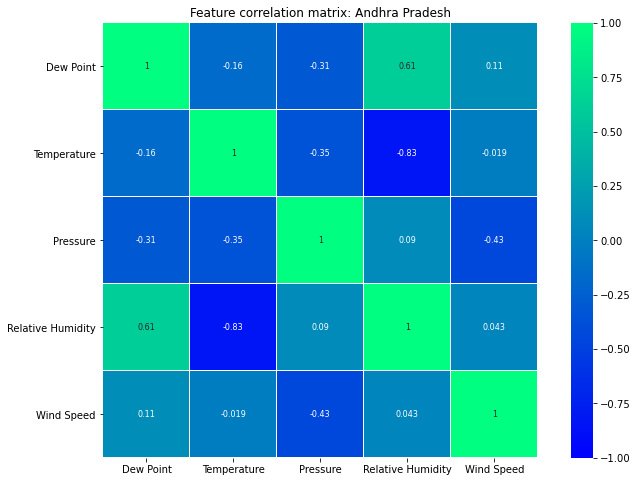

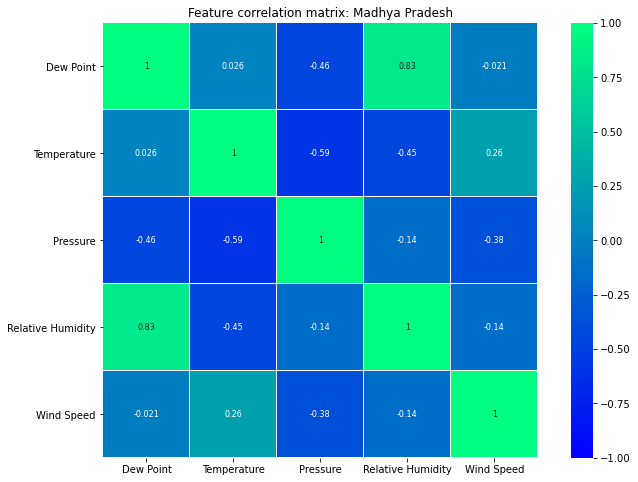

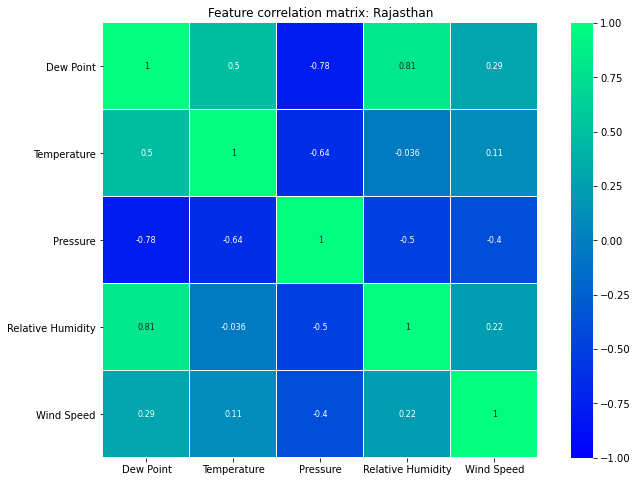

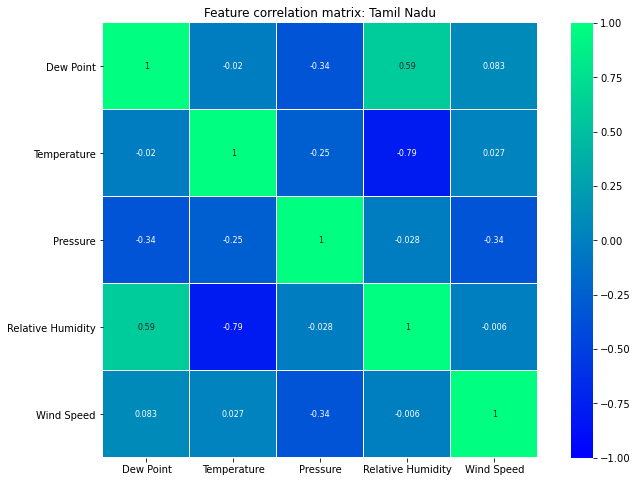

In [ ]:
dataframes = [AP_data , MP_data, RJ_data , TN_data]
for dataframex in dataframes:
  dataframe_attributes = dataframex[['Dew Point','Temperature','Pressure','Relative Humidity', 'Wind Speed']]
  correlations = dataframe_attributes.corr() 
  plt.figure(figsize=(12, 8))
  axes = plt.axes()
  axes.set_title('Feature correlation matrix: ' + str(dataframex.name))
  sborn.heatmap(correlations, cmap='winter', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True);

# NORMALITY TEST, BEST FIT DISTRIBUTIONS #

Normality Test : Two tests performed at 5% LOS
* Shapiro Wilk Test
* D'Agnostino's K^2 Test

In [ ]:
alphanorm = 0.05

for dataframex in dataframes:
    plt.figure(figsize=(12, 8))
    axes = plt.axes()
    axes.set_title('Histogram: '+str(dataframex.name))
    plt.hist(dataframex['Wind Speed'])
    
    #Shapiro Wilk Test
    statnorm, pnorm = st.shapiro(dataframex['Wind Speed'])
    print('\n\n\n'+dataframex.name+':\nShapiro-Wilk Statistic=%.3f, p=%.3f' % (statnorm, pnorm))

    if pnorm > alphanorm:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
        
    #D'Agnostino's K^2 Test
    statnorm, pnorm = st.normaltest(dataframex['Wind Speed'])
    print('\nD\'Agnostino\'s K^2 Statistic=%.3f, p=%.3f' % (statnorm, pnorm))

    if pnorm > alphanorm:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

NameError: ignored

Best Fit Distributions : Checking from various distributions such as Beta, Weibull, Rayleigh, etc. as data was seen to be not normal.

In [ ]:
warnings.filterwarnings('default')
warnings.simplefilter('default')

In [ ]:
for dataframex in dataframes:
    mydistr=dataframex['Wind Speed']
    mydistr_x = np.linspace(mydistr.min(),mydistr.max(),1000)
    #sborn.set_style("whitegrid")
    distribution_list = [  
        st.beta,st.gamma,st.rayleigh,st.norm,st.logistic,st.weibull_min,st.weibull_max,st.lognorm,st.chi,st.expon,st.invgamma,st.loggamma,st.loglaplace,st.chi2,st.cosine
    ]

    distribution_fitting = []

    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for ref_distr in distribution_list:
          distr_name = str(type(ref_distr)).split(".")[-1][:-6]



          params = ref_distr.fit(mydistr)
          arg = params[:-2]
          loc = params[-2]
          scale = params[-1]

          pdf_fitted = ref_distr.pdf(mydistr_x,loc=loc,scale=scale,*arg)

          mle = ref_distr.nnlf(params, mydistr)
          sse = np.sum(np.power(mydistr_x - pdf_fitted, 2.0))

          distribution_fitting.append({"distr_name": distr_name, "mle": mle, "sse":sse,"pdf_fitted": pdf_fitted, "params": params})



    # plot data histograms
    fig, ax = plt.subplots(1,1,dpi=120)
    _ = ax.hist(mydistr, mydistr_x, density=True, color="green", alpha=0.4)  

    top = 3

    ax.set_prop_cycle('color',plt.cm.rainbow(np.linspace(0,1,top)))
    ax.set_title(dataframex.name+": Best fitting PDFs")

    sort_by = "mle" # or sse
    for d in sorted(distribution_fitting, key=lambda k: k[sort_by])[:top]:
        distr_name = d['distr_name']
        mle = d['mle']
        pdf_fitted = d['pdf_fitted']
        params = d['params']

        label = "{} [{:.2f}]".format(distr_name,mle)
        _ = ax.plot(mydistr_x, pdf_fitted, label=label)

    _ = ax.legend()

# TIME SERIES DECOMPOSITION, STATIONARITY TEST #
Time Series Decomposition : Additive model is used as the seasonality does not seem to vary much with level

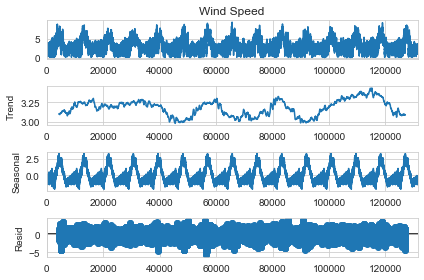

In [ ]:
df_AP = pd.concat([AP_data['Date_Time'],AP_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
df_AP.set_index('Date_Time')
decomp_AP = seasonal_decompose(df_AP['Wind Speed'], model='additive', period=365*24)
decomp_AP.plot()
plt.show()

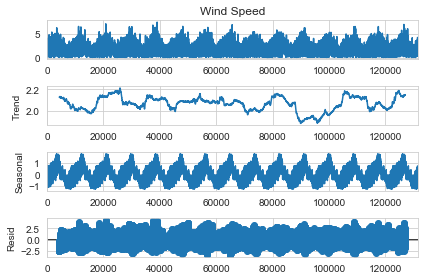

In [ ]:
df_MP = pd.concat([MP_data['Date_Time'],MP_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
df_MP.set_index('Date_Time')
decomp_MP = seasonal_decompose(df_MP['Wind Speed'], model='additive', period=365*24)
decomp_MP.plot()
plt.show()

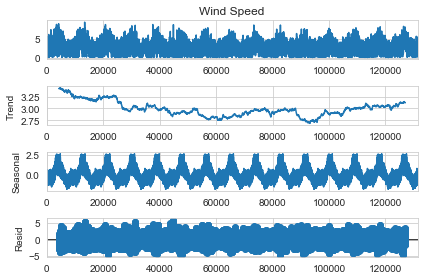

In [ ]:
df_RJ = pd.concat([RJ_data['Date_Time'],RJ_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
df_RJ.set_index('Date_Time')
decomp_RJ = seasonal_decompose(df_RJ['Wind Speed'], model='additive', period=365*24)
decomp_RJ.plot()
plt.show()

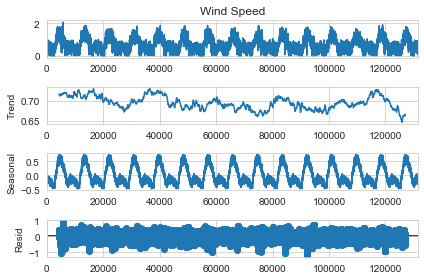

In [ ]:
df_TN = pd.concat([TN_data['Date_Time'],TN_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
df_TN.set_index('Date_Time')
decomp_TN = seasonal_decompose(df_TN['Wind Speed'], model='additive', period=365*24)
decomp_TN.plot()
plt.show()

Stationarity Test: Two tests are performed at 1% LOS. Series found to be stationary
* ADF (Parametric) 

In [ ]:
datasets=[AP_data, MP_data, RJ_data, TN_data]
for dataset in datasets:
    adf_result=adfuller(dataset['Wind Speed'])
    print('Test Stat: '+str(adf_result[0])+'\np-value: '+str(adf_result[1])+'\nCrit value at 1% LOS: '+str(adf_result[4]['1%'])+'\nCrit value at 5% LOS: '+str(adf_result[4]['5%'])+'\nCrit value at 10% LOS: '+str(adf_result[4]['10%'])+'\n\n')

Test Stat: -13.419314697388598
p-value: 4.2204640597949785e-25
Crit value at 1% LOS: -3.4303997953780967
Crit value at 5% LOS: -2.8615620088348286
Crit value at 10% LOS: -2.5667817145225587


Test Stat: -21.875115048848524
p-value: 0.0
Crit value at 1% LOS: -3.4303997953780967
Crit value at 5% LOS: -2.8615620088348286
Crit value at 10% LOS: -2.5667817145225587


Test Stat: -22.487712452767557
p-value: 0.0
Crit value at 1% LOS: -3.4303997953780967
Crit value at 5% LOS: -2.8615620088348286
Crit value at 10% LOS: -2.5667817145225587


Test Stat: -11.656812627312476
p-value: 1.976389307362444e-21
Crit value at 1% LOS: -3.4303997953780967
Crit value at 5% LOS: -2.8615620088348286
Crit value at 10% LOS: -2.5667817145225587




* KPSS (Non-Parametric)

In [ ]:
for dataset in datasets:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kpss_result = kpss(dataset['Wind Speed'])
        print('Test Stat: '+str(kpss_result[0])+'\np-value: '+str(kpss_result[1])+'\nnum lags: '+str(kpss_result[2])+'\nCrit value at 1% LOS: '+str(kpss_result[3]['1%'])+'\nCrit value at 5% LOS: '+str(kpss_result[3]['5%'])+'\nCrit value at 10% LOS: '+str(kpss_result[3]['10%'])+'\n\n')

Test Stat: 0.15758708105037433
p-value: 0.1
num lags: 73
Crit value at 1% LOS: 0.739
Crit value at 5% LOS: 0.463
Crit value at 10% LOS: 0.347


Test Stat: 0.3601461711453459
p-value: 0.09433354692010952
num lags: 73
Crit value at 1% LOS: 0.739
Crit value at 5% LOS: 0.463
Crit value at 10% LOS: 0.347


Test Stat: 1.9474099510337564
p-value: 0.01
num lags: 73
Crit value at 1% LOS: 0.739
Crit value at 5% LOS: 0.463
Crit value at 10% LOS: 0.347


Test Stat: 0.17282498421379994
p-value: 0.1
num lags: 73
Crit value at 1% LOS: 0.739
Crit value at 5% LOS: 0.463
Crit value at 10% LOS: 0.347




# TIME SERIES ANALYSIS #
Model parameters estimated based on one state (AP). Predictions will be made using these models for all states.

First, PACF is plotted. It is found to be hard to do any parameter estimation on hourly data, and the computation time is large.

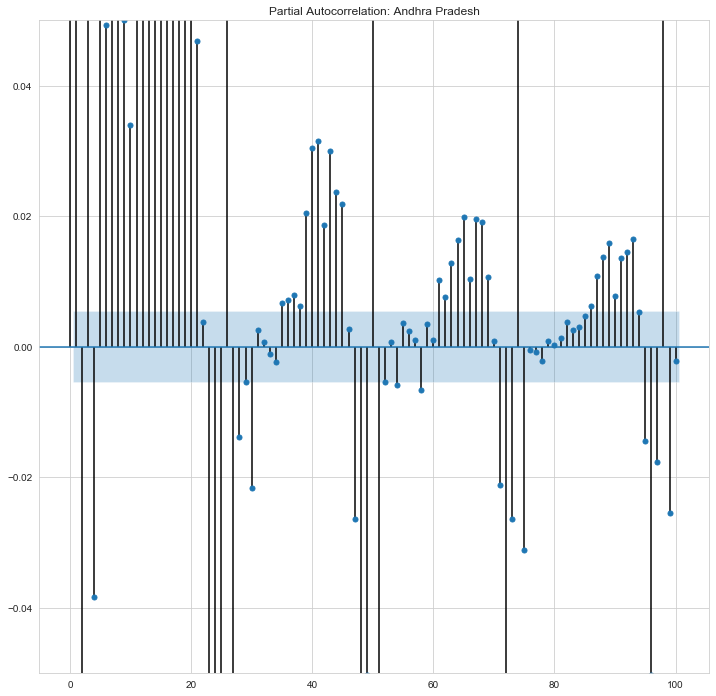

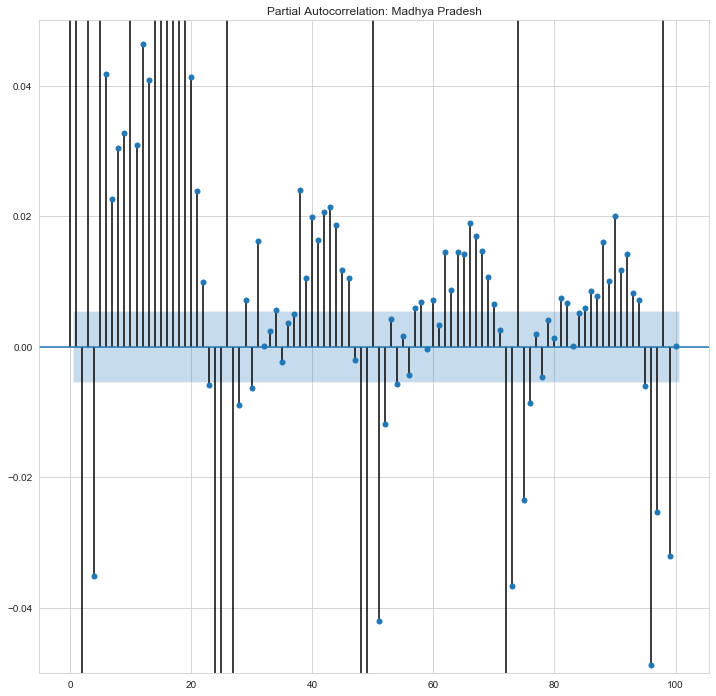

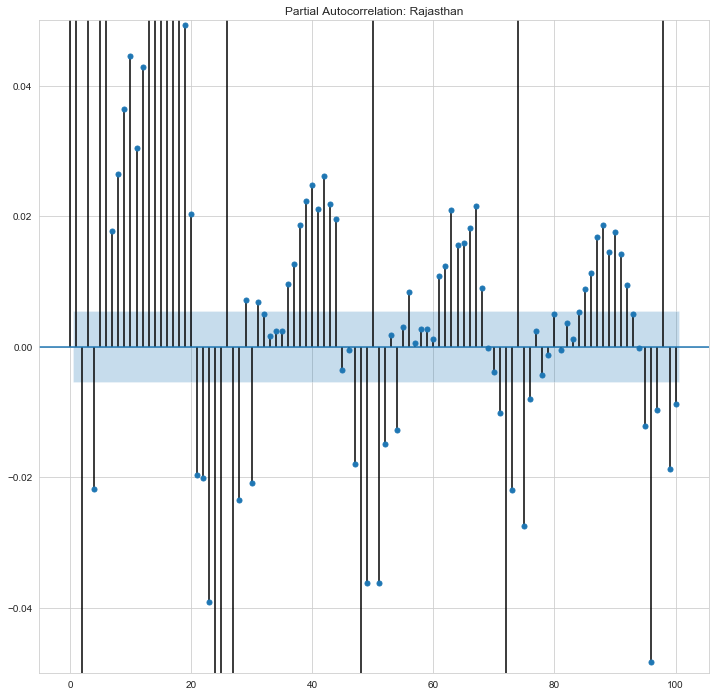

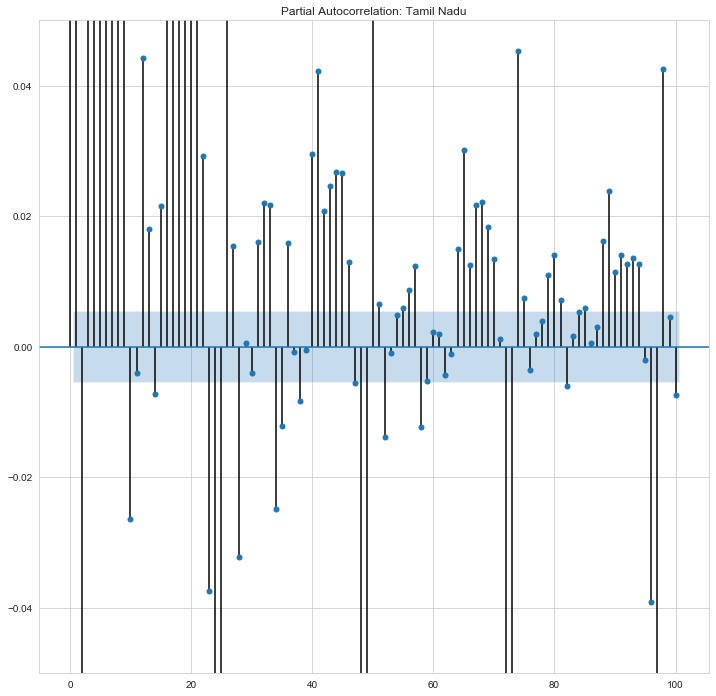

In [ ]:
datasets=[AP_data, MP_data, RJ_data, TN_data]
#datasets=[AP_data]
for dataset in datasets:
    fig1=plt.figure(figsize=(12,12))
    ax1=plt.axes()
    ax1.set_ylim(-0.05,0.05)
    pacf = plot_pacf(dataset['Wind Speed'],ax=ax1,lags = 100,alpha=0.05, title='Partial Autocorrelation: '+dataset.name)

Data is converted to daily data using mean Wind Speeds.

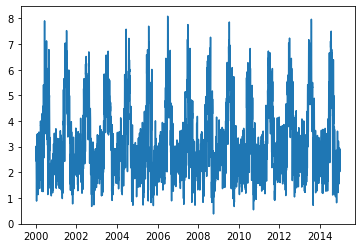

In [ ]:
tmp_df = pd.concat([AP_data['Date_Time'],AP_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
AP_daily = tmp_df.groupby(tmp_df['Date_Time'].dt.date).mean().reset_index()
AP_daily.set_index('Date_Time')
AP_daily.name = 'Andhra Pradesh'
plt.plot(AP_daily['Date_Time'],AP_daily['Wind Speed'])

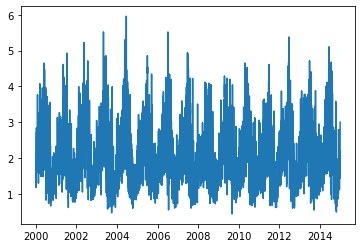

In [ ]:
tmp_df = pd.concat([MP_data['Date_Time'],MP_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
MP_daily = tmp_df.groupby(tmp_df['Date_Time'].dt.date).mean().reset_index()
MP_daily.set_index('Date_Time')
MP_daily.name = 'Madhya Pradesh'
plt.plot(MP_daily['Date_Time'],MP_daily['Wind Speed'])

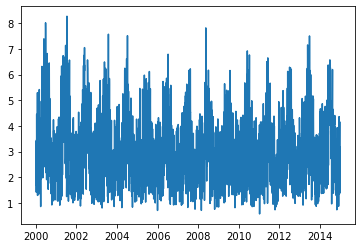

In [ ]:
tmp_df = pd.concat([RJ_data['Date_Time'],RJ_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
RJ_daily = tmp_df.groupby(tmp_df['Date_Time'].dt.date).mean().reset_index()
RJ_daily.set_index('Date_Time')
RJ_daily.name = 'Rajasthan'
plt.plot(RJ_daily['Date_Time'],RJ_daily['Wind Speed'])

In [ ]:
RJ_daily.shape

(5475, 2)

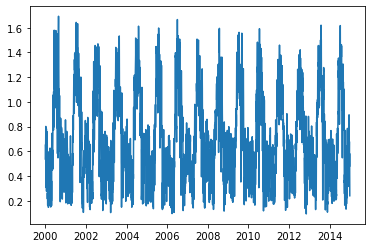

In [ ]:
tmp_df = pd.concat([TN_data['Date_Time'],TN_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
TN_daily = tmp_df.groupby(tmp_df['Date_Time'].dt.date).mean().reset_index()
TN_daily.set_index('Date_Time')
TN_daily.name = 'Tamil Nadu'
plt.plot(TN_daily['Date_Time'],TN_daily['Wind Speed'])

PACF for daily data is plotted. Values of AR model order estimates are noted for each state's daily data (9, 18, 16, 11)

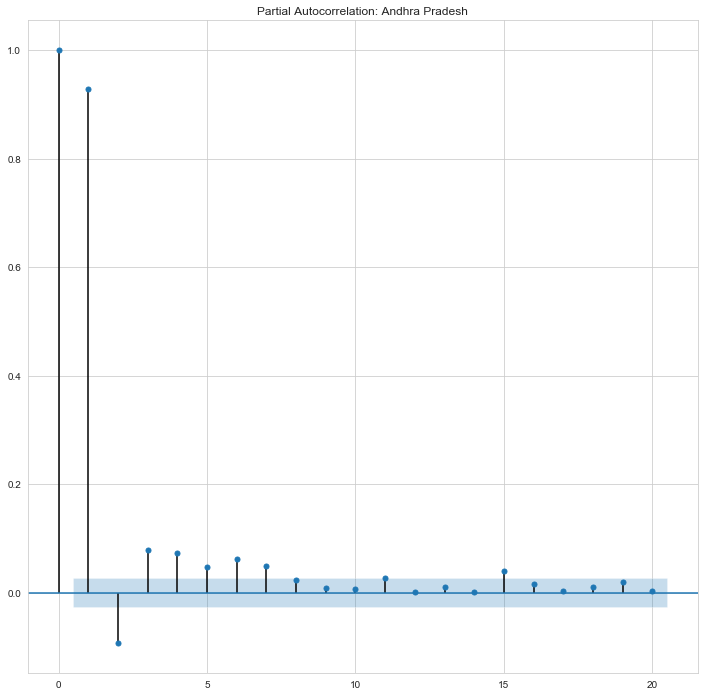

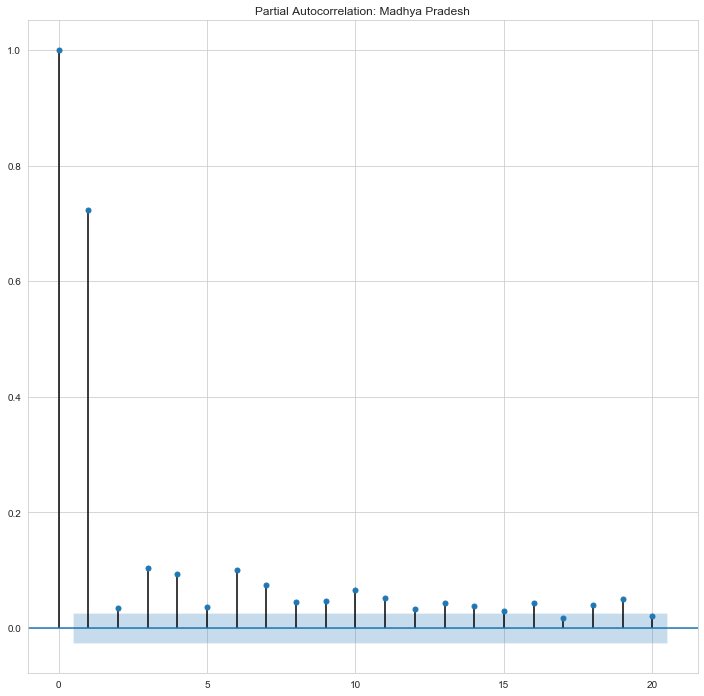

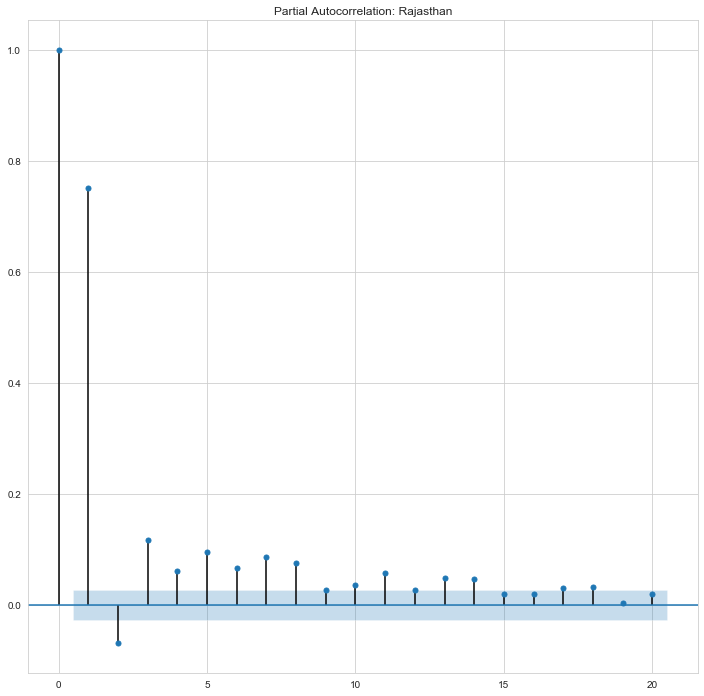

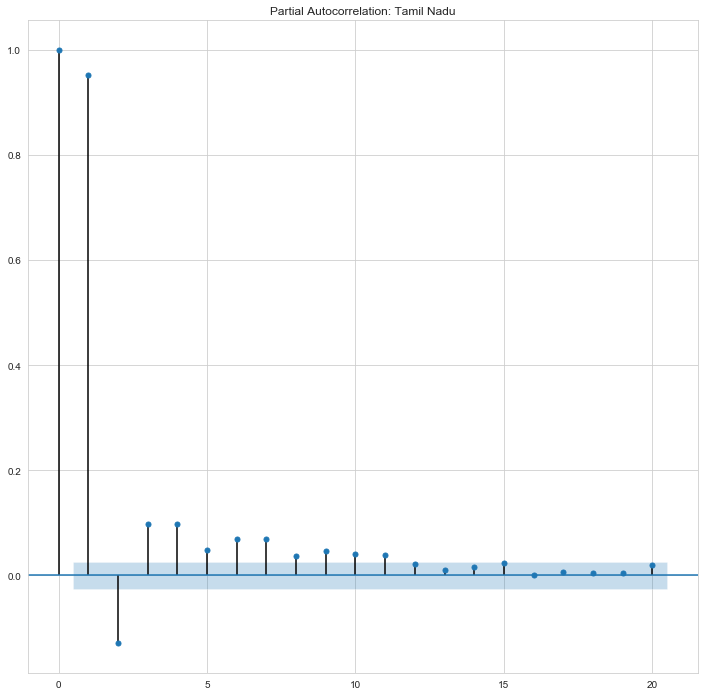

In [ ]:
predsets=[AP_daily, MP_daily, RJ_daily, TN_daily]
#predsets=[AP_daily]
for dataset in predsets:
    fig1=plt.figure(figsize=(12,12))
    ax1=plt.axes()
    #ax1.set_ylim(-0.05,0.05)
    pacf = plot_pacf(dataset['Wind Speed'],ax=ax1,lags = 20,alpha=0.05, title='Partial Autocorrelation: '+dataset.name)

# AR Model

                               SARIMAX Results                                
Dep. Variable:             Wind Speed   No. Observations:                 5475
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -4043.709
Date:                Sat, 24 Apr 2021   AIC                           8109.417
Time:                        19:25:49   BIC                           8182.105
Sample:                             0   HQIC                          8134.777
                               - 5475                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1668      0.126     25.084      0.000       2.919       3.414
ar.L1          1.0055      0.012     86.965      0.000       0.983       1.028
ar.L2         -0.1617      0.017     -9.472      0.0

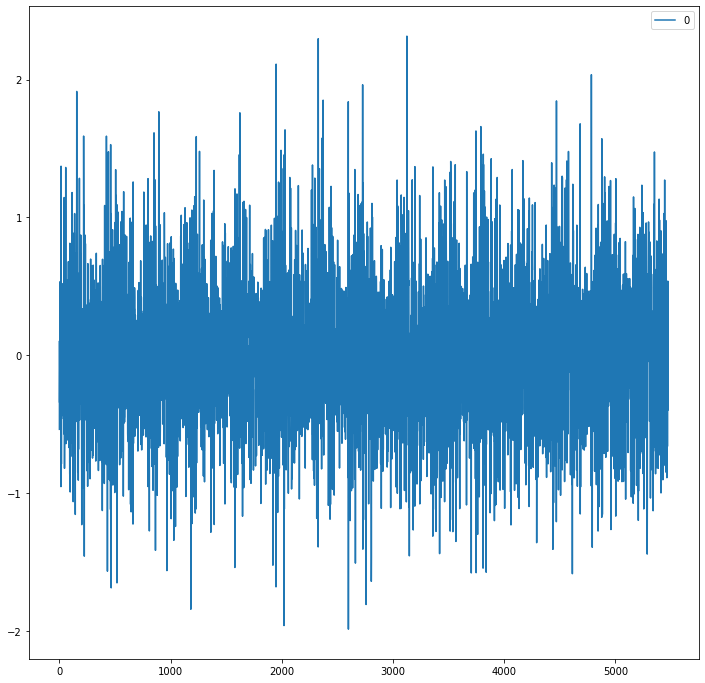

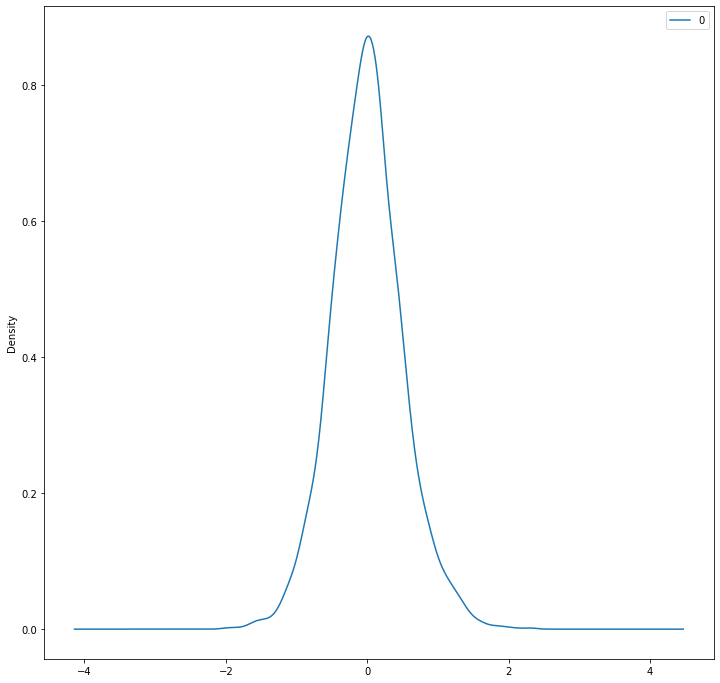

In [ ]:
ar_AP = ARIMA(AP_daily['Wind Speed'],order=(9,0,0)) #Use (AP - 9, MP - 18, RJ - 16, TN - 11)
ar_fit_AP = ar_AP.fit()
print(ar_fit_AP.summary())
ar_res_AP = pd.DataFrame(ar_fit_AP.resid)

fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
ar_res_AP.plot(ax=ax1)
fig2=plt.figure(figsize=(12,12))
ax2=plt.axes()
ar_res_AP.plot(kind='kde',ax=ax2)
print('\nResiduals data description:')
print(ar_res_AP.describe())



Mean Absolute Percentage Error (Andhra Pradesh): 15.047300771386118 %


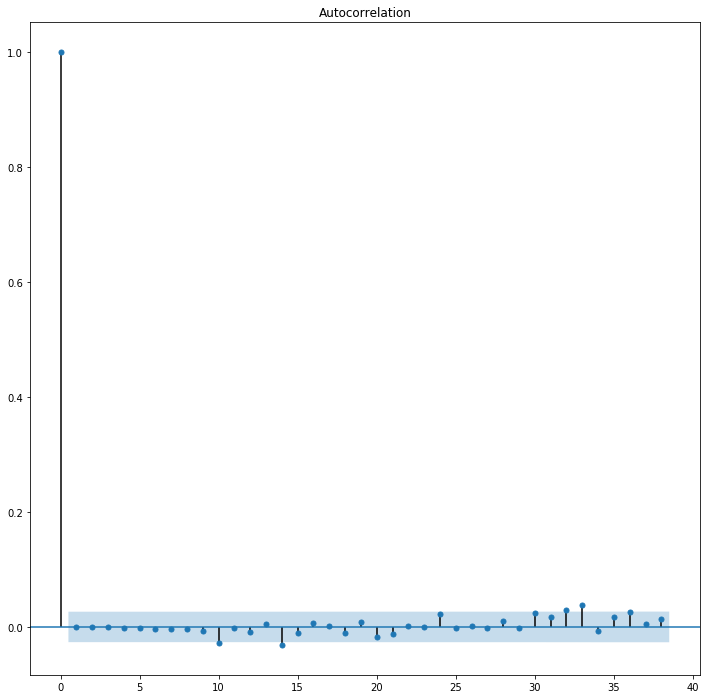

In [ ]:
percentage = []
for i in range(len(ar_res_AP)):
  if (AP_daily['Wind Speed'][i]==0):
    continue
  percentage.append((abs(ar_res_AP[0][i])/(AP_daily['Wind Speed'][i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_daily.name+"): {0} %".format(mape))

fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
acf_plot = plot_acf(ar_res_AP, ax=ax1) #Low autocorrelation seen - can be assumed as WGN

# MA Model
Ideally we should use 56 order MA as seen below, but due to large training times, lesser values are used from here on out.

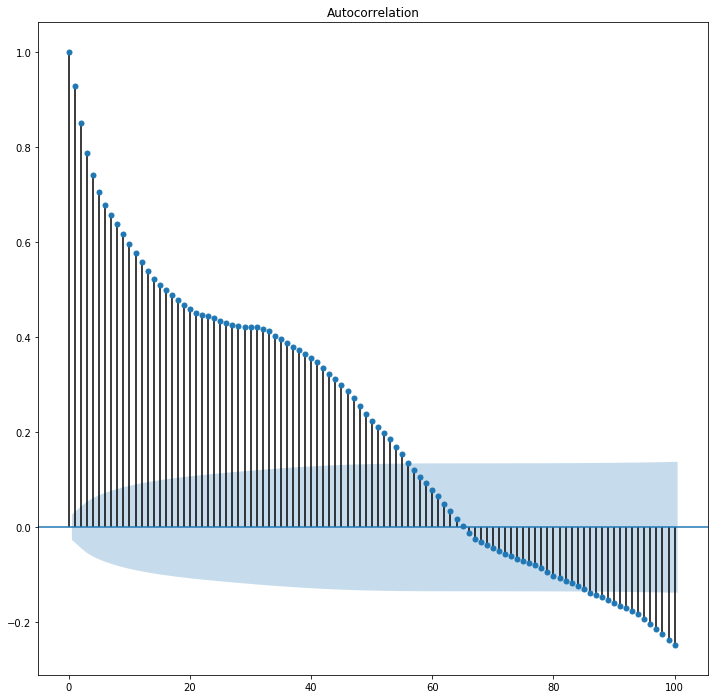

In [ ]:
fig2=plt.figure(figsize=(12,12))
ax2=plt.axes()
acf = plot_acf(AP_daily['Wind Speed'],ax=ax2,lags = 100) #Estimating order of MA

                               SARIMAX Results                                
Dep. Variable:             Wind Speed   No. Observations:                 5475
Model:                ARIMA(0, 0, 20)   Log Likelihood               -4099.718
Date:                Sat, 24 Apr 2021   AIC                           8243.435
Time:                        08:21:26   BIC                           8388.810
Sample:                             0   HQIC                          8294.154
                               - 5475                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1705      0.068     46.480      0.000       3.037       3.304
ma.L1          1.0248      0.012     87.494      0.000       1.002       1.048
ma.L2          0.8837      0.017     51.118      0.0

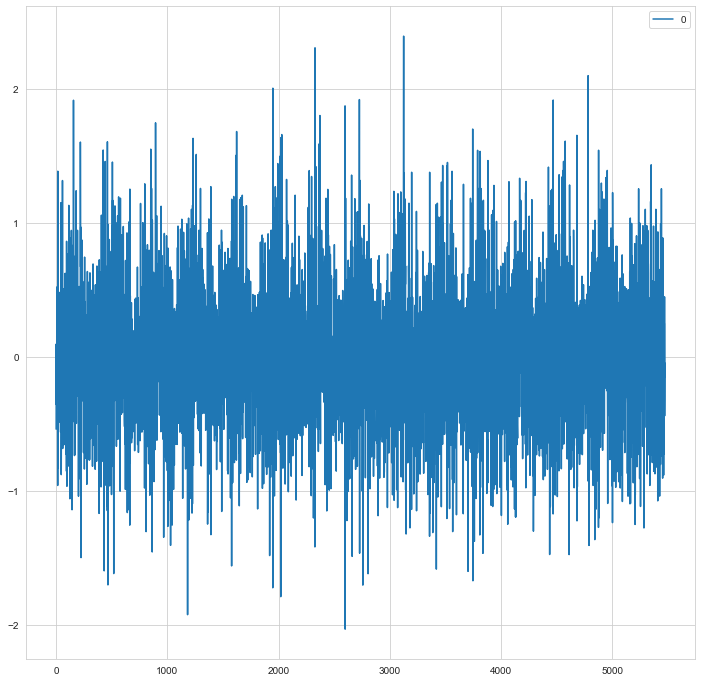

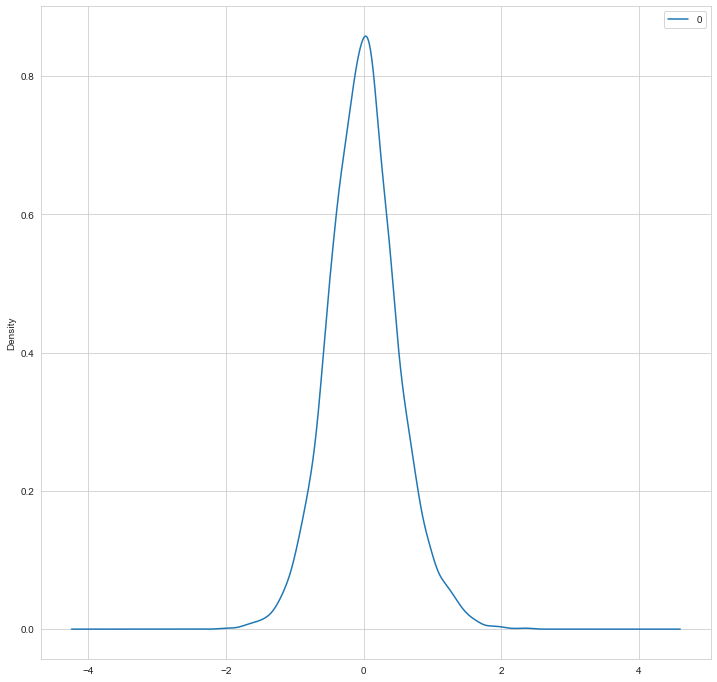

In [ ]:
ma_AP = ARIMA(AP_daily['Wind Speed'],order=(0,0,20))
ma_fit_AP = ma_AP.fit()
print(ma_fit_AP.summary())
ma_res_AP = pd.DataFrame(ma_fit_AP.resid)
fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
ma_res_AP.plot(ax=ax1)
fig2=plt.figure(figsize=(12,12))
ax2=plt.axes()
ma_res_AP.plot(kind='kde',ax=ax2)
print('\nResiduals data description:')
print(ma_res_AP.describe())



Mean Absolute Percentage Error (Andhra Pradesh): 15.239381935322278 %


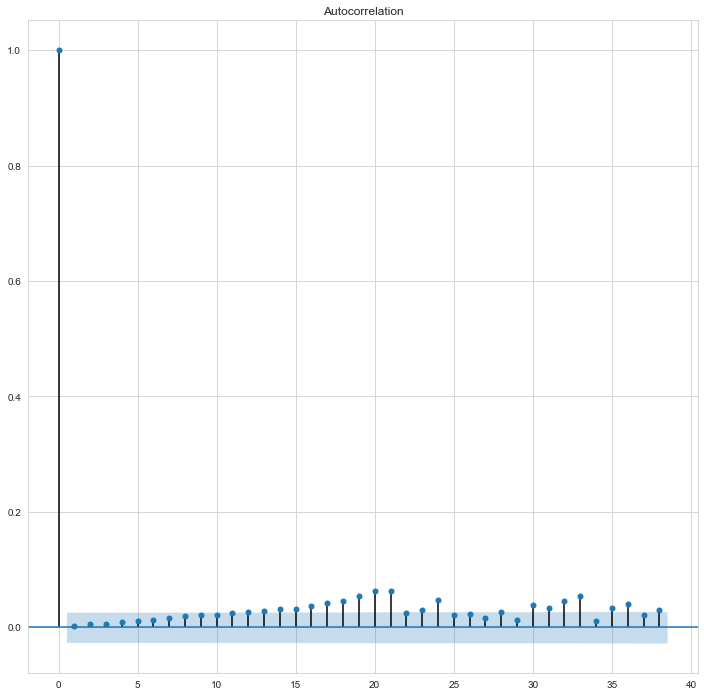

In [ ]:
fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
acf_plot = plot_acf(ma_res_AP, ax=ax1) # Seen to be significant at mid-high lag levels

percentage = []
for i in range(len(ma_res_AP)):
  if AP_daily['Wind Speed'][i]==0:
    continue
  percentage.append((abs(ma_res_AP[0][i])/(AP_daily['Wind Speed'][i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_daily.name+"): {0} %".format(mape))

# ARMA Model
Grid search performed, model found as (9,0,11)

In [ ]:
mape_low=100
p_low=9
q_low=10
for p in range(9,14):
    for q in range(10, 15):
        arma_AP = ARIMA(AP_daily['Wind Speed'],order=(p,0,q))
        arma_fit_AP = arma_AP.fit()
        #print(arma_fit_AP.summary())
        arma_res_AP = pd.DataFrame(arma_fit_AP.resid)
        
        percentage = []
        for i in range(len(arma_res_AP)):
          if AP_daily['Wind Speed'][i]==0:
            continue
          percentage.append((abs(arma_res_AP[0][i])/(AP_daily['Wind Speed'][i]))*100)
        mape = sum(percentage)/len(percentage)
        if(mape<mape_low):
            mape_low=mape
            p_low=p
            q_low=q
print(p_low)
print(q_low)            

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-pac

9
11


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:             Wind Speed   No. Observations:                 5475
Model:                ARIMA(9, 0, 11)   Log Likelihood               -4014.599
Date:                Sat, 24 Apr 2021   AIC                           8073.198
Time:                        19:13:09   BIC                           8218.573
Sample:                             0   HQIC                          8123.917
                               - 5475                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1524      0.119     26.519      0.000       2.919       3.385
ar.L1          0.5455      4.460      0.122      0.903      -8.196       9.287
ar.L2          0.9099      5.348      0.170      0.8

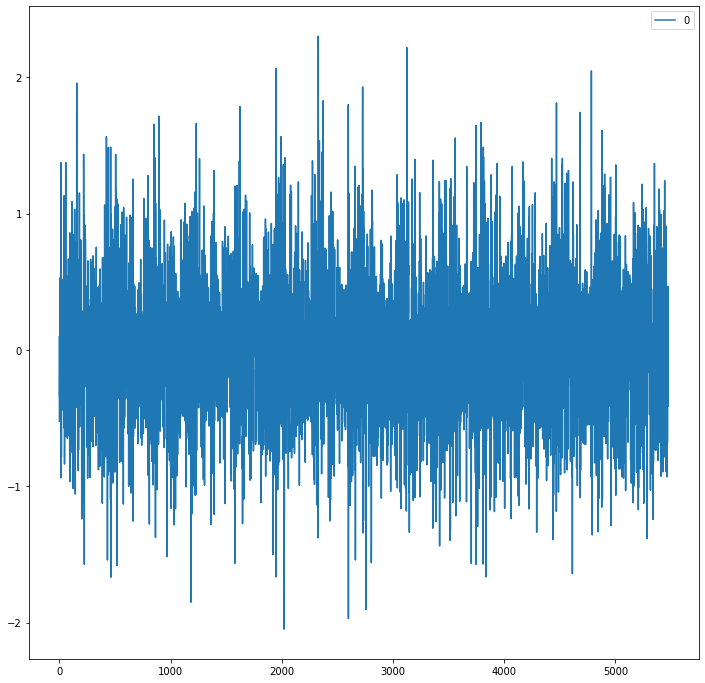

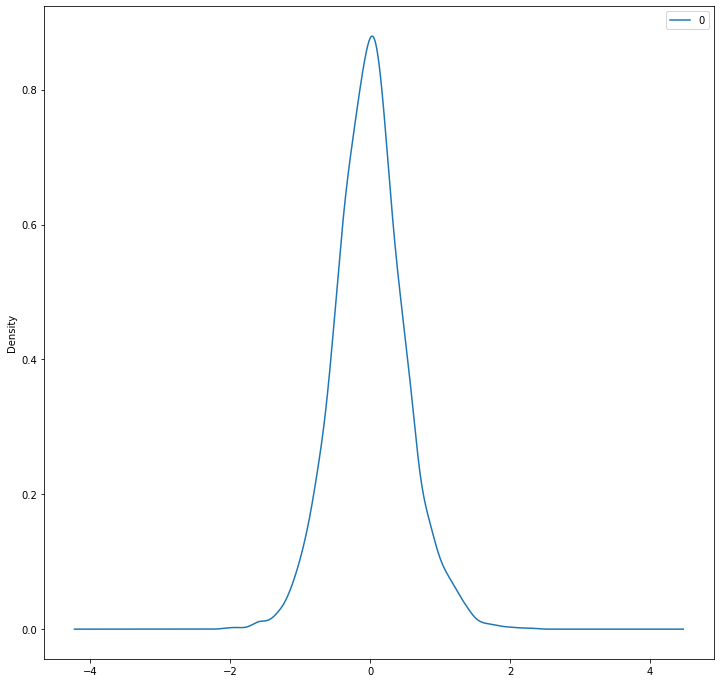

In [ ]:
arma_AP = ARIMA(AP_daily['Wind Speed'],order=(9,0,11))
arma_fit_AP = arma_AP.fit()
print(arma_fit_AP.summary())
arma_res_AP = pd.DataFrame(arma_fit_AP.resid)
fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
arma_res_AP.plot(ax=ax1)
fig2=plt.figure(figsize=(12,12))
ax2=plt.axes()
arma_res_AP.plot(kind='kde',ax=ax2)
print('\nResiduals data description:')
print(arma_res_AP.describe())



Mean Absolute Percentage Error (Andhra Pradesh): 14.991010448972625 %


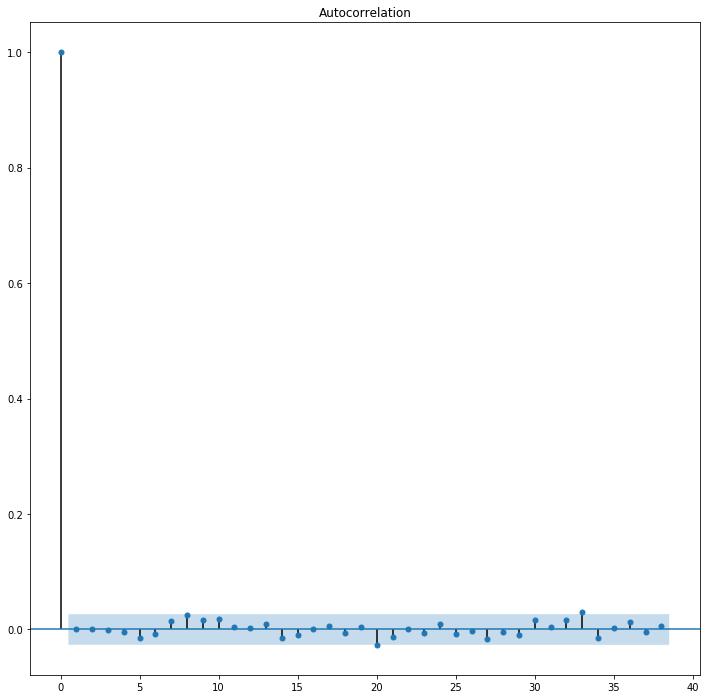

In [ ]:
fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
acf_plot = plot_acf(arma_res_AP, ax=ax1) # Seen to be significant at mid-high lag levels

percentage = []
for i in range(len(arma_res_AP)):
  if AP_daily['Wind Speed'][i]==0:
    continue
  percentage.append((abs(arma_res_AP[0][i])/(AP_daily['Wind Speed'][i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_daily.name+"): {0} %".format(mape))

# ARIMA Model
Grid search was performed to find d=1.

In [ ]:
mape_low=100
d_low=1
for d in range(1,5):
    arima_AP = ARIMA(AP_daily['Wind Speed'],order=(9,d,11))
    arima_fit_AP = arima_AP.fit()
    #print(arma_fit_AP.summary())
    arima_res_AP = pd.DataFrame(arima_fit_AP.resid)
        
    percentage = []
    for i in range(len(arima_res_AP)):
        if AP_daily['Wind Speed'][i]==0:
            continue
        percentage.append((abs(arima_res_AP[0][i])/(AP_daily['Wind Speed'][i]))*100)
    mape = sum(percentage)/len(percentage)
    if(mape<mape_low):
        mape_low=mape
        d_low=d
print(d_low)    

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:             Wind Speed   No. Observations:                 5475
Model:                ARIMA(9, 1, 11)   Log Likelihood               -4053.130
Date:                Sat, 24 Apr 2021   AIC                           8148.260
Time:                        19:38:49   BIC                           8287.023
Sample:                             0   HQIC                          8196.672
                               - 5475                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1725      3.875      0.045      0.964      -7.421       7.767
ar.L2         -0.1098      1.208     -0.091      0.928      -2.478       2.258
ar.L3          0.0075      0.819      0.009      0.9

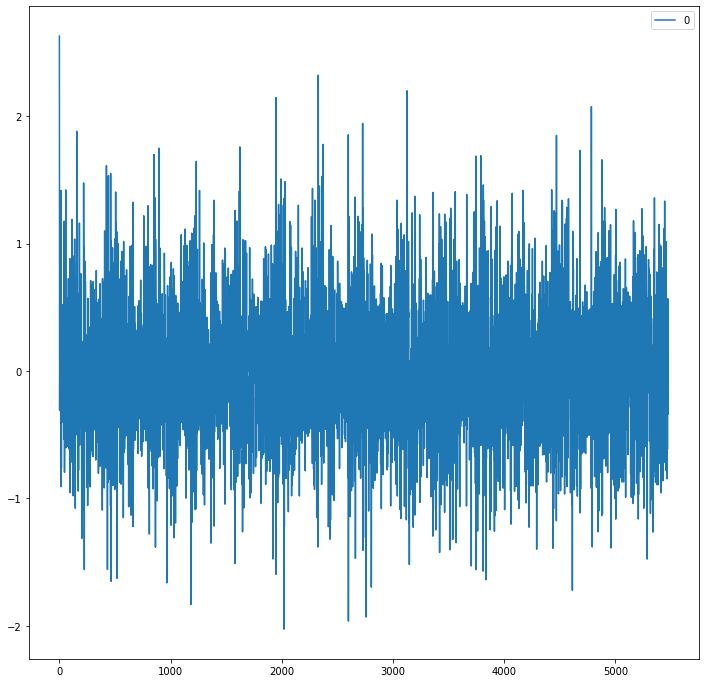

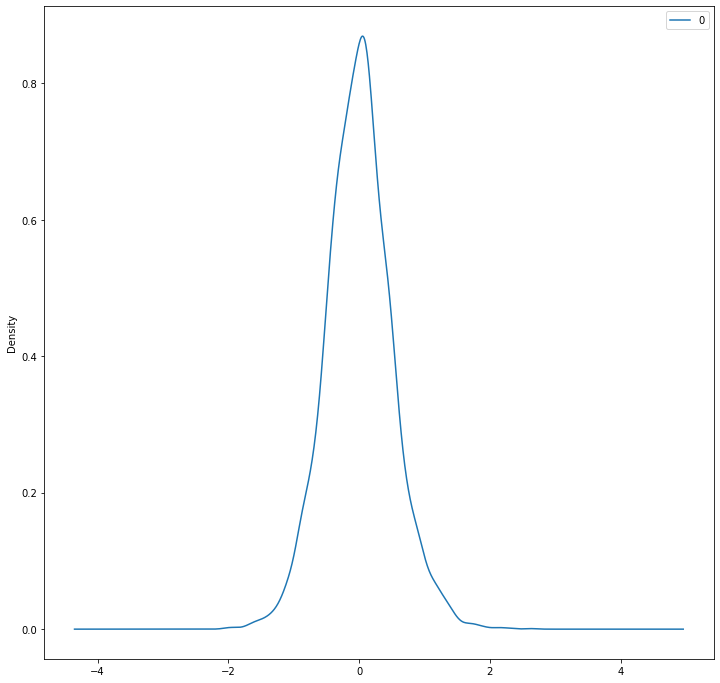

In [ ]:
arima_AP = ARIMA(AP_daily['Wind Speed'],order=(9,1,11))
arima_fit_AP = arima_AP.fit()
print(arima_fit_AP.summary())
arima_res_AP = pd.DataFrame(arima_fit_AP.resid)
fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
arima_res_AP.plot(ax=ax1)
fig2=plt.figure(figsize=(12,12))
ax2=plt.axes()
arima_res_AP.plot(kind='kde',ax=ax2)
print('\nResiduals data description:')
print(arima_res_AP.describe())



Mean Absolute Percentage Error (Andhra Pradesh): 15.097684019341074 %


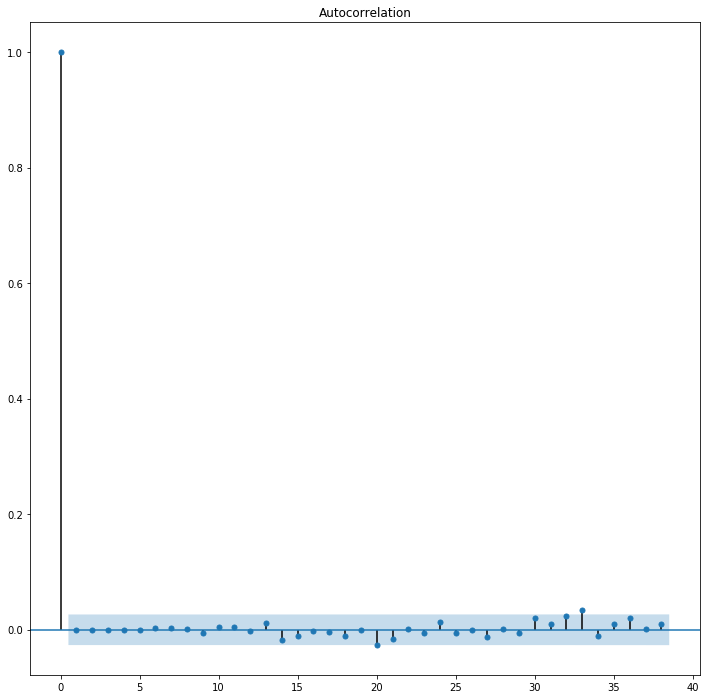

In [ ]:
fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
acf_plot = plot_acf(arima_res_AP, ax=ax1) # Seen to be significant at mid-high lag levels

percentage = []
for i in range(len(arima_res_AP)):
  if AP_daily['Wind Speed'][i]==0:
    continue
  percentage.append((abs(arima_res_AP[0][i])/(AP_daily['Wind Speed'][i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_daily.name+"): {0} %".format(mape))

# SARIMA Model
Very expensive computationally. Data converted to monthly - S=12 for yearly seasonality that was observed in decomposition

,Date_Time,Wind Speed
0,2000-01-31,2.505607
1,2000-02-29,2.250484
2,2000-03-31,2.584497
3,2000-04-30,2.545664
4,2000-05-31,3.286441


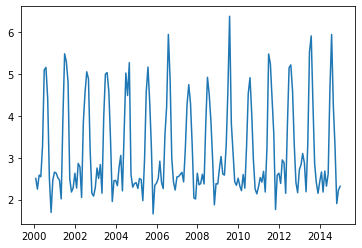

In [ ]:
tmp_df = pd.concat([AP_data['Date_Time'],AP_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
tmp_df.set_index('Date_Time', inplace=True)
AP_monthly = tmp_df.groupby(pd.Grouper(freq="M")).mean().reset_index()
AP_monthly.set_index('Date_Time')
AP_monthly.name = 'Andhra Pradesh'
plt.plot(AP_monthly['Date_Time'],AP_monthly['Wind Speed'])
AP_monthly.head()

,Date_Time,Wind Speed
0,2000-01-31,1.998494
1,2000-02-29,2.264716
2,2000-03-31,2.549402
3,2000-04-30,2.489526
4,2000-05-31,3.086157


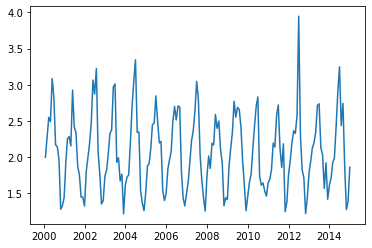

In [ ]:
tmp_df = pd.concat([MP_data['Date_Time'],MP_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
tmp_df.set_index('Date_Time', inplace=True)
MP_monthly = tmp_df.groupby(pd.Grouper(freq="M")).mean().reset_index()
MP_monthly.set_index('Date_Time')
MP_monthly.name = 'Madhya Pradesh'
plt.plot(MP_monthly['Date_Time'],MP_monthly['Wind Speed'])
MP_monthly.head()

,Date_Time,Wind Speed
0,2000-01-31,2.895304
1,2000-02-29,2.767930
2,2000-03-31,3.019269
3,2000-04-30,3.785158
4,2000-05-31,5.111881


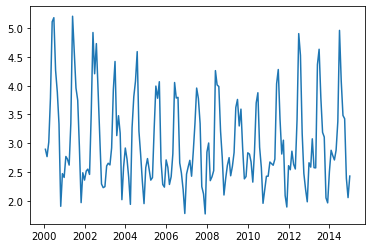

In [ ]:
tmp_df = pd.concat([RJ_data['Date_Time'],RJ_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
tmp_df.set_index('Date_Time', inplace=True)
RJ_monthly = tmp_df.groupby(pd.Grouper(freq="M")).mean().reset_index()
RJ_monthly.set_index('Date_Time')
RJ_monthly.name = 'Rajasthan'
plt.plot(RJ_monthly['Date_Time'],RJ_monthly['Wind Speed'])
RJ_monthly.head()

,Date_Time,Wind Speed
0,2000-01-31,0.573986
1,2000-02-29,0.349708
2,2000-03-31,0.358298
3,2000-04-30,0.401208
4,2000-05-31,0.777291


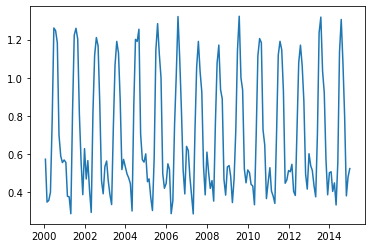

In [ ]:
tmp_df = pd.concat([TN_data['Date_Time'],TN_data['Wind Speed']],axis=1,keys=["Date_Time","Wind Speed"])
tmp_df.set_index('Date_Time', inplace=True)
TN_monthly = tmp_df.groupby(pd.Grouper(freq="M")).mean().reset_index()
TN_monthly.set_index('Date_Time')
TN_monthly.name = 'Tamil Nadu'
plt.plot(TN_monthly['Date_Time'],TN_monthly['Wind Speed'])
TN_monthly.head()

Grid Search gives us values of order and seasonal order for the monthly data (2,0,3),(1,0,1). This will be our model for predictions.

In [ ]:
mape_low=100
p_low=1
d_low=1
q_low=1
P_low=1
D_low=1
Q_low=1
p=1
q=1
d=1
P=1
Q=1
D=1
for p in [1,2,3]:
    for d in [0]:
        for q in [1,2,3]:
            for P in [1,2]:
                for D in [0,1]:
                    for Q in [0,1]:
                        print('Testing '+str(p)+' '+str(d)+' '+str(q)+' '+str(P)+' '+str(D)+' '+str(Q)+' ')
                        sarima_AP = SARIMAX(AP_monthly['Wind Speed'], order = (p,d,q),seasonal_order=(P,D,Q,12))
                        sarima_fit_AP = sarima_AP.fit()
                        #print(sarima_fit_AP.summary())
                        sarima_res_AP = pd.DataFrame(sarima_fit_AP.resid)

                        percentage = []
                        for i in range(len(sarima_res_AP)):
                            if AP_daily['Wind Speed'][i]==0:
                                continue
                            percentage.append((abs(sarima_res_AP[0][i])/(AP_monthly['Wind Speed'][i]))*100)
                        mape = sum(percentage)/len(percentage)
                        if(mape<mape_low):
                            mape_low=mape
                            p_low=p
                            d_low=d
                            q_low=q
                            P_low=P
                            D_low=D
                            Q_low=Q
print(p_low)    
print(d_low) 
print(q_low) 
print(P_low) 
print(D_low) 
print(Q_low) 

Testing 1 0 1 1 0 0 
Testing 1 0 1 1 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 1 0 1 1 1 0 
Testing 1 0 1 1 1 1 
Testing 1 0 1 2 0 0 
Testing 1 0 1 2 0 1 
Testing 1 0 1 2 1 0 
Testing 1 0 1 2 1 1 
Testing 1 0 2 1 0 0 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 1 0 2 1 0 1 
Testing 1 0 2 1 1 0 
Testing 1 0 2 1 1 1 
Testing 1 0 2 2 0 0 
Testing 1 0 2 2 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 1 0 2 2 1 0 
Testing 1 0 2 2 1 1 
Testing 1 0 3 1 0 0 
Testing 1 0 3 1 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 1 0 3 1 1 0 
Testing 1 0 3 1 1 1 
Testing 1 0 3 2 0 0 
Testing 1 0 3 2 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 1 0 3 2 1 0 
Testing 1 0 3 2 1 1 
Testing 2 0 1 1 0 0 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 1 1 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 1 1 1 0 
Testing 2 0 1 1 1 1 
Testing 2 0 1 2 0 0 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 1 2 0 1 
Testing 2 0 1 2 1 0 
Testing 2 0 1 2 1 1 
Testing 2 0 2 1 0 0 
Testing 2 0 2 1 0 1 
Testing 2 0 2 1 1 0 
Testing 2 0 2 1 1 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 2 2 0 0 
Testing 2 0 2 2 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 2 2 1 0 
Testing 2 0 2 2 1 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 3 1 0 0 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 3 1 0 1 
Testing 2 0 3 1 1 0 
Testing 2 0 3 1 1 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 3 2 0 0 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 3 2 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 2 0 3 2 1 0 
Testing 2 0 3 2 1 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 3 0 1 1 0 0 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 3 0 1 1 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 3 0 1 1 1 0 
Testing 3 0 1 1 1 1 
Testing 3 0 1 2 0 0 
Testing 3 0 1 2 0 1 
Testing 3 0 1 2 1 0 
Testing 3 0 1 2 1 1 
Testing 3 0 2 1 0 0 
Testing 3 0 2 1 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 3 0 2 1 1 0 
Testing 3 0 2 1 1 1 
Testing 3 0 2 2 0 0 
Testing 3 0 2 2 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 3 0 2 2 1 0 
Testing 3 0 2 2 1 1 
Testing 3 0 3 1 0 0 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 3 0 3 1 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 3 0 3 1 1 0 
Testing 3 0 3 1 1 1 
Testing 3 0 3 2 0 0 
Testing 3 0 3 2 0 1 


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing 3 0 3 2 1 0 
Testing 3 0 3 2 1 1 
2
0
3
1
0
1


                                      SARIMAX Results                                       
Dep. Variable:                           Wind Speed   No. Observations:                  180
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 -80.086
Date:                              Sat, 24 Apr 2021   AIC                            176.171
Time:                                      21:31:57   BIC                            201.715
Sample:                                           0   HQIC                           186.528
                                              - 180                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0775      0.067      1.156      0.248      -0.054       0.209
ar.L2          0.92

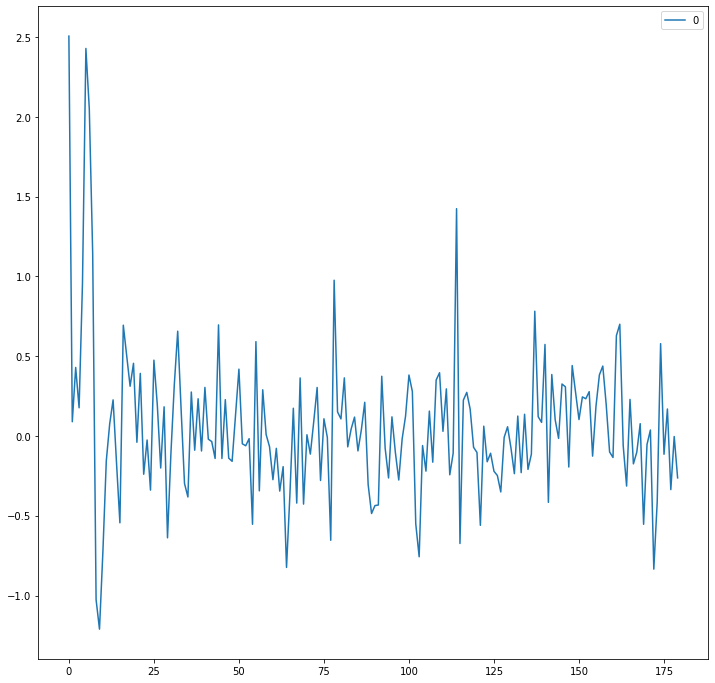

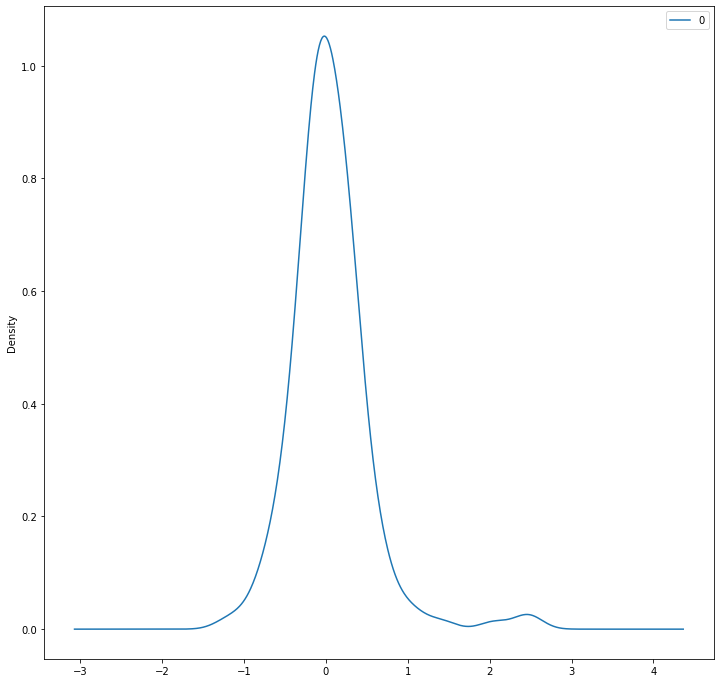

In [ ]:
sarima_AP = SARIMAX(AP_monthly['Wind Speed'], order = (2,0,3),seasonal_order=(1,0,1,12))
sarima_fit_AP = sarima_AP.fit()
print(sarima_fit_AP.summary())
sarima_res_AP = pd.DataFrame(sarima_fit_AP.resid)

fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
sarima_res_AP.plot(ax=ax1)

fig2=plt.figure(figsize=(12,12))
ax2=plt.axes()
sarima_res_AP.plot(kind='kde',ax=ax2)

print('\nResiduals data description:')
print(sarima_res_AP.describe())



Mean Absolute Percentage Error (Andhra Pradesh): 10.28581371948779 %


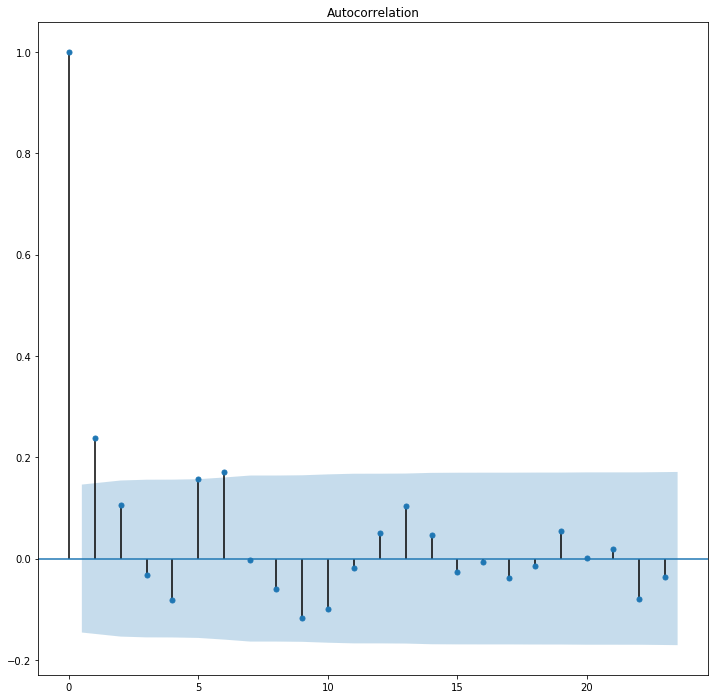

In [ ]:
fig1=plt.figure(figsize=(12,12))
ax1=plt.axes()
acf_plot = plot_acf(sarima_res_AP, ax=ax1) 

percentage = []
for i in range(len(sarima_res_AP)):
    if AP_daily['Wind Speed'][i]==0:
        continue
    percentage.append((abs(sarima_res_AP[0][i])/(AP_monthly['Wind Speed'][i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_monthly.name+"): {0} %".format(mape))

The final prediction models for AP are:
* AR (9)
* MA (20)
* ARMA (9,11)
* ARIMA (9,1,11)
* SARIMA (2,0,3), (1,0,1,12)

The first four predict daily forecast and monthly forecast, the final one predicts only monthly forecast

# Forecasting/Prediction

Sample split into training and testing sets (99% training for daily forecasting - 54 days left to predict and compare). 

In [ ]:
train_len = int((len(AP_daily)*90)/100) #Manual 99% train test split
train = AP_daily['Wind Speed'][0:train_len]
test = AP_daily['Wind Speed'][train_len:len(AP_daily)]

In [ ]:
len(AP_daily)

5475

In [ ]:
len(AP_daily)-train_len

274

In [ ]:
train_len

5201

In [ ]:
test[5202]

2.708409900466601

# AR Forecast

In [ ]:
hist = train.copy()

preds = []
for t in range(len(test)): 
    print(t)
    ar_AP = ARIMA(hist,order = (9,0,0),enforce_stationarity=False,enforce_invertibility=True)
    ar_fit_AP = ar_AP.fit()
    output=ar_fit_AP.forecast()
    preds.append(output[train_len+t])
    hist[len(hist)]=test[train_len+t]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511




Mean Absolute Percentage Error (Andhra Pradesh): 15.973560053239792 %
Mean Square Error (Andhra Pradesh): 0.25916982539328925


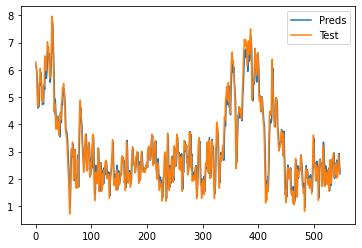

In [ ]:
percentage = []
for i in range(len(preds)):
    percentage.append((abs(preds[i]-test[train_len+i])/(test[train_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_daily.name+"): {0} %".format(mape))

test_pts = [x for x in test]

mse = mean_squared_error(test_pts,preds)
print("Mean Square Error ("+AP_daily.name+"): {0}".format(mse))

plt.plot(preds)
plt.plot(test_pts)
plt.legend(('Preds','Test'))

# MA Forecast

In [ ]:
hist = train.copy()

preds = []
for t in range(len(test)): 
    print(t)
    ma_AP = ARIMA(hist,order = (0,0,11),enforce_stationarity=False,enforce_invertibility=True) #Scaled down from 20 due to long computation time
    ma_fit_AP = ma_AP.fit()
    output=ma_fit_AP.forecast()
    preds.append(output[train_len+t])
    hist[len(hist)]=test[train_len+t]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27



Mean Absolute Percentage Error (Andhra Pradesh): 16.629054659604133 %
Mean Square Error (Andhra Pradesh): 0.2832471223023445


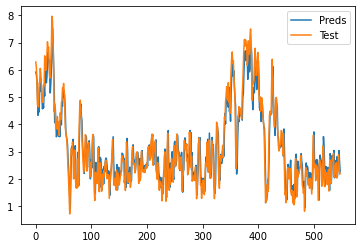

In [ ]:
percentage = []
for i in range(len(preds)):
    percentage.append((abs(preds[i]-test[train_len+i])/(test[train_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_daily.name+"): {0} %".format(mape))

test_pts = [x for x in test]

mse = mean_squared_error(test_pts,preds)
print("Mean Square Error ("+AP_daily.name+"): {0}".format(mse))

plt.plot(preds)
plt.plot(test_pts)
plt.legend(('Preds','Test'))

# ARMA Forecast

In [ ]:
hist = train.copy()

preds = []
for t in range(len(test)): 
    print(t)
    arma_AP = ARIMA(hist,order = (2,0,3),enforce_stationarity=False,enforce_invertibility=True) #Scaled down from 9,11 due to long computation time
    arma_fit_AP = arma_AP.fit()
    output=arma_fit_AP.forecast()
    preds.append(output[train_len+t])
    hist[len(hist)]=test[train_len+t]

0


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1
2
3
4
5


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6
7
8


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10
11


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12
13


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16
17
18
19
20
21
22
23


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24
25
26


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


27
28
29
30
31
32


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


33


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


34
35
36
37


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


38


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


39
40
41
42
43
44
45
46


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


47


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48
49
50
51
52


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53
54
55


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


56
57
58


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


129
130
131
132
133


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


134
135
136
137
138
139


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


140
141
142
143
144


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


187
188
189
190
191
192
193
194


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


195
196
197
198
199


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


200


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


254
255
256
257
258
259
260
261
262
263
264
265


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


345
346
347
348
349


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


350
351
352
353
354
355
356


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


357
358
359


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


360
361
362
363
364
365
366


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


367
368
369


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


370


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


371
372
373
374


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


375
376
377
378
379
380
381
382
383
384
385
386


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


387
388
389
390
391
392
393


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


394
395


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


396
397
398
399


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


400
401
402
403
404
405
406


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


407
408
409
410
411
412


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


413


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


414
415
416
417
418
419
420
421
422


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


542
543
544
545
546
547




Mean Absolute Percentage Error (Andhra Pradesh): 15.997085719557017 %
Mean Square Error (Andhra Pradesh): 0.2588442983890618


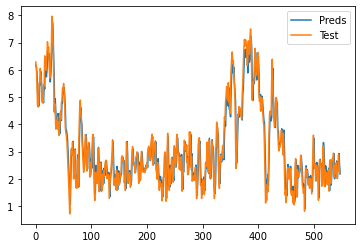

In [ ]:
percentage = []
for i in range(len(preds)):
    percentage.append((abs(preds[i]-test[train_len+i])/(test[train_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_daily.name+"): {0} %".format(mape))

test_pts = [x for x in test]

mse = mean_squared_error(test_pts,preds)
print("Mean Square Error ("+AP_daily.name+"): {0}".format(mse))

plt.plot(preds)
plt.plot(test_pts)
plt.legend(('Preds','Test'))

# ARIMA Forecast

In [ ]:
hist = train.copy()

preds = []
for t in range(len(test)): 
    print(t)
    arima_AP = ARIMA(hist,order = (2,1,3),enforce_stationarity=False,enforce_invertibility=True) #Scaled down from 9,1,11 due to long computation time
    arima_fit_AP = arima_AP.fit()
    output=arima_fit_AP.forecast()
    preds.append(output[train_len+t])
    hist[len(hist)]=test[train_len+t]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27



Mean Absolute Percentage Error (Andhra Pradesh): 16.090867927477483 %
Mean Square Error (Andhra Pradesh): 0.2616456265716812


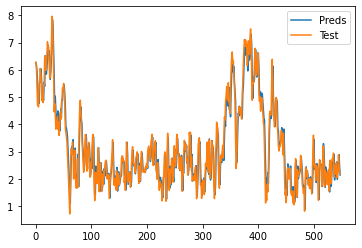

In [ ]:
percentage = []
for i in range(len(preds)):
    percentage.append((abs(preds[i]-test[train_len+i])/(test[train_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_daily.name+"): {0} %".format(mape))

test_pts = [x for x in test]

mse = mean_squared_error(test_pts,preds)
print("Mean Square Error ("+AP_daily.name+"): {0}".format(mse))

plt.plot(preds)
plt.plot(test_pts)
plt.legend(('Preds','Test'))

# SARIMA Forecast

In [ ]:
train_len = int((len(AP_monthly)*70)/100) #Manual 80% train test split
train = AP_monthly['Wind Speed'][0:train_len]
test = AP_monthly['Wind Speed'][train_len:len(AP_monthly)]
print(train_len)
print(len(AP_monthly)-train_len)

126
54


In [ ]:
hist = train.copy()

preds = []
for t in range(len(test)): 
    print(t)
    sarima_AP = SARIMAX(hist, order = (2,0,3),seasonal_order=(1,0,1,12),enforce_stationarity=False,enforce_invertibility=True)
    sarima_fit_AP = sarima_AP.fit()
    output=sarima_fit_AP.forecast()
    preds.append(output[train_len+t])
    hist[len(hist)]=test[train_len+t]

0


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


25


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


26


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


27


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


28


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


29


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


30


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


31


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


32


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


33


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


34


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


35


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


36


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


37


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


38


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


39


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


40


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


41


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


42


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


43


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


44


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


45


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


47


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


49


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


51


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


52


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53


D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




Mean Absolute Percentage Error (Andhra Pradesh): 8.234168583344756 %
Mean Square Error (Andhra Pradesh): 0.11277325846015673


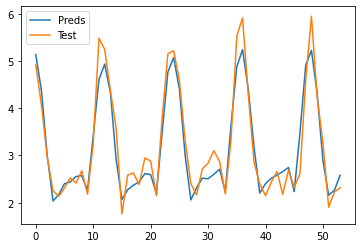

In [ ]:
percentage = []
for i in range(len(preds)):
    percentage.append((abs(preds[i]-test[train_len+i])/(test[train_len+i]))*100)
mape = sum(percentage)/len(percentage)
print("\n\nMean Absolute Percentage Error ("+AP_monthly.name+"): {0} %".format(mape))

test_pts = [x for x in test]

mse = mean_squared_error(test_pts,preds)
print("Mean Square Error ("+AP_monthly.name+"): {0}".format(mse))

plt.plot(preds)
plt.plot(test_pts)
plt.legend(('Preds','Test'))